
## Method of Lines - quick excercise

We have the wave equation 

$$ -\partial_{tt} \Phi+\partial_{xx} \Phi = 0$$

which we rewrite as first-rder system
$$ \partial_{t} \left(\begin{array}{cc}\Phi\\ \chi\end{array}\right) = \left(\begin{array}{cc}\chi\\ \partial_{xx} \Phi\end{array}\right)$$

We then consider initial data in the form
$$\Phi(t=0) = \sin^n(k x),~~~\chi(t=0) =0$$
With proper value of $k$ it satisfies fixed-end boundary condition

$$ \partial_{t} \left(\begin{array}{cc}\Phi\\ \chi\end{array}\right) = \left(\begin{array}{cc}\chi\\ 0\end{array}\right)$$

Since the exact solution is periodic we can evaluate absolute error.



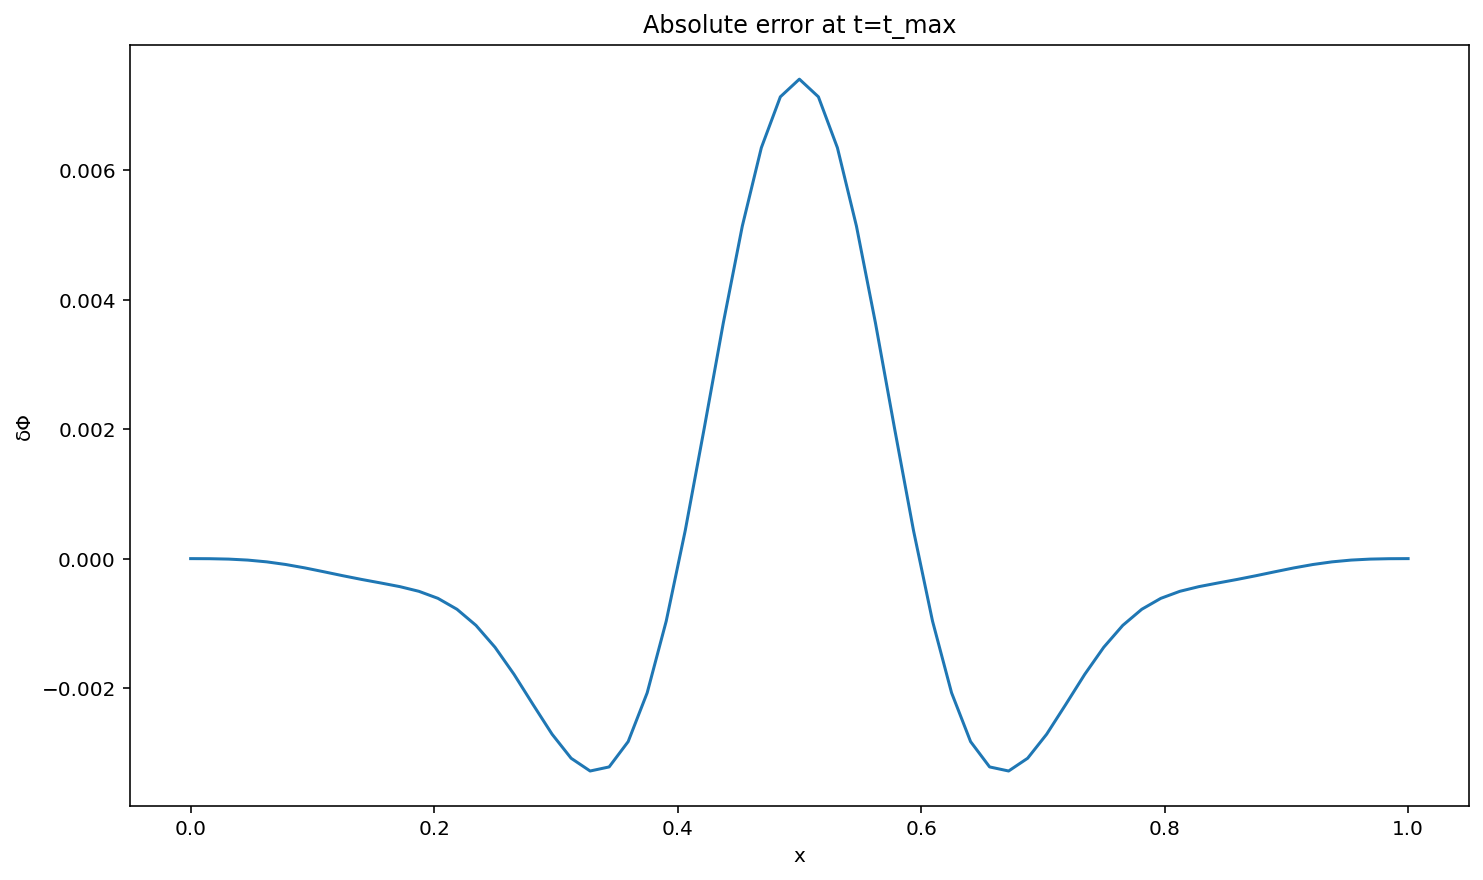

In [1]:
import numpy as np
import matplotlib.pyplot as plt

iPhi = 0
iChi = 1

def RK3Step(x, u, dt, rhs) :
  assert len(u[0]) == len(x);
  dt3 = dt/3.;
  u1 = u + dt3*rhs(x, u);
  u2 = u + 2*dt3*rhs(x, u1);
  u3 = u1 + dt*rhs(x, u2);
  return 0.75*u3 + 0.25*u

def waveEqRSH(x, u) :
  phi = u[ iPhi ]
  chi = u[ iChi ]

  # first equation
  dPhi_dt = chi

  # second equation needs second partial derivative w.r.t. x
  dx = x[1]-x[0]    # Assuming equidistant array
  dxx_phi = (1/(dx*dx))*(phi[2:]-2*phi[1:-1]+phi[:-2])
  dChi_dt = np.concatenate( ( [0.], dxx_phi ,[0.] ) )

  # assemble both results and return
  return np.array( [ dPhi_dt, dChi_dt ] )

#  x-domain parameters
x_min = 0
x_max = 1
n_div = 64
dx    = (x_max-x_min) /n_div

#  timestep
t_max = 2       # final time 

cfl   = 0.8
dt    = cfl*dx     # assuming speed == 1
times = np.arange(0,t_max+dt,dt)

# plot results
anim_frames = 64
plot_times = times[0 : : int(len(times)/anim_frames)]   # select frames to animate
plot_data  = []

# grid, inial data and evolved variables
x = np.arange(x_min,x_max+dx,dx)
chi0 = 0*x         # simplest way to create same-length vector
phi0 = np.sin(np.pi*x/(x_max-x_min))**10

# phi0 = np.sin(4*np.pi*x/(x_max-x_min))   # simple standing wave as another test 

u0 = np.array( [phi0,chi0] )


# evolution
u     = u0
for t in times:
    if t in plot_times: plot_data.append(u[iPhi])
    u = RK3Step(x,u,dt,waveEqRSH)


# show error

plt.plot(x,phi0-u[0])
plt.xlabel("x")
plt.ylabel("δΦ")
plt.title("Absolute error at t=t_max")
plt.show()

In [5]:
# The following code defines two auxiliary functions we use later to produce animation
# do not bother reading, simply execute :)

frame_DPI = 75    # how large the movie frames should be

def animAppendFrame(movie):
    """Append current Matplotlib figure to move as a PIL Image"""
    import io
    import os
    from PIL import Image

    fig = plt.gcf()
    buf = io.BytesIO()
    fig.savefig(buf,dpi=frame_DPI)
    buf.seek(0)
    img = Image.open(buf)
    movie.append( img )
    plt.close()

def animShow(movie):
    # trick to display animations in jupyteru
    unique_prefix = 'animgwzqh_'

    use_random_name = True   # random names defy browser's caching

    rnd_file = unique_prefix+'0.gif'
    if use_random_name:
        import random
        #os.system('rm -f ' + unique_prefix + '*.gif')
        rnd_file = unique_prefix+str(random.randrange(1000001,9000001))+'.gif'

    # join all frames of movie[] into one gif
    movie[0].save(rnd_file, format='GIF',
               append_images=movie[1:],
               save_all=True, duration=2, loop=0)

    # display in Jupyter notebook !
    from IPython.display import Image as inlineImg
    from IPython.display import display
    display( inlineImg(url=rnd_file)  )



In [6]:
# animate field evolution

xframes = []    
print('Please wait, preparing animation...')

for i in range(len(plot_data)):
    plt.plot(x,plot_data[i])
    plt.plot(x,phi0,linestyle='dashed')
    plt.ylim(-1.1,1.1)
    plt.xlabel("x")
    plt.ylabel("Φ")
    plt.title("t="+str(plot_times[i]))
    animAppendFrame(xframes)
    
animShow(xframes)

Please wait, preparing animation...


## Problems

1. Observe, how error δΦ and time needed to run the code depend of `n_div`
  
  a) If the number of gridpoints is $2\times$ greater, how much the error decrease?
  
  b) If the number of gridpoints is $2\times$ greater, how much the time needed to evolve from 0 to `t_max` increase?

2. Using bisection and increasing `n_div` find the onset of instability due to CFL condition, i.e. the threashold value of `cfl`

  Show, that this value is in good agreement with the theoretical one, which arises from 

  (i) discretisation of the derivative operator 
  $$\partial_{xx} f(x) \rightarrow \frac{f(x-\Delta x)-2f(x)+f(x+\Delta x)}{(\Delta x)^{2}}$$
   which has the usual eigenfunction of the derivative operator, i.e., $ e^{ikx}$, but with eigenvalue $\lambda^2= - 4(\Delta x)^{-2} \sin^2(k \Delta x/2)$ instead of $-k^2$ of $\partial_{xx}$;

   (ii) 3rd order Runge-Kutta method, which for differential equation $\partial_t U = \Lambda U$ approximates the exact solution $\exp(\Lambda t)$ by its Taylor expansion up to $t^3$;

   (iii) diagonalisation of matrix $[(0,~1),(-\lambda^2,~0)]$ which has eigenvalues $\Lambda = \pm i \lambda$;

   (iv) and the existence of maximal spatial frequency $k_{\rm max}$ which can exist on  grid with given $\Delta x$ which is also demonstrated by upper bound of the eigenvalue $\lambda$.

3.  Implement so-called radiation boundary  condtions
$$ 
\partial_{t} \left(\begin{array}{cc}\Phi\\ \chi  \end{array}\right) 
= 
\left(\begin{array}{cc}\chi\\ \pm \partial_{x} \chi   \end{array}\right)
$$
Here the $+$ sign holds at $x=0$ and $-$ sign at $x=1$. Use the first order finite differece at boundary $f'(x_i) = [f(x_i)-f(x_{i-1})]/dx$.

Use the inital data $\phi=0$ and $\chi$ given by prescription `np.sin(np.pi*x/(x_max-x_min))**10`.

4. Rewrite the code (3.) for the equivalent system which uses auxiliary field $\psi = \partial_x \phi$
$$ 
\partial_{t} \left(\begin{array}{cc}\Phi\\ \chi \\ \psi \end{array}\right) 
= 
\left(\begin{array}{cc}\chi\\ \partial_{x} \psi \\ \partial_x \chi\end{array}\right)
$$


5. Find the maximal theoretical value of the CFL factor for (4.) with second-order centred differences $\partial_x f(x)\approx [f(x+\Delta x)-f(x-\Delta x)]/(2\Delta x)$ 